In [1]:
import os, sys
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from asteroid.metrics import get_metrics
from pprint import pprint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.empty_cache()

# Get the pretrained models
print("Pre-trained models available:")
for model_name in os.listdir('../../pretrained_models'):
    print(model_name)
    
def normalize_tensor_wav(wav_tensor, eps=1e-8, std=None):
    mean = wav_tensor.mean(-1, keepdim=True)
    if std is None:
        std = wav_tensor.std(-1, keepdim=True)
    return (wav_tensor - mean) / (std + eps)
    
anechoic_model_p = '../../pretrained_models/GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt'
anechoic_model_p = '../../pretrained_models/Improved_Sudormrf_U16_Bases512_WSJ02mix.pt'
anechoic_model_p = '../../pretrained_models/Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt'
noisy_reverberant_model_p = '../../pretrained_models/Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.pt'
noisy_reverberant_model_p = '../../pretrained_models/Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt'

# Load the appropriate class modules
sys.path.append("../../")
import sudo_rm_rf.dnn.models.improved_sudormrf as improved_sudormrf
import sudo_rm_rf.dnn.models.groupcomm_sudormrf_v2 as sudormrf_gc_v2

Pre-trained models available:
Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.pt
improved_sudo_epoch_500
GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt
Improved_Sudormrf_U16_Bases512_WSJ02mix.pt
Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt
Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt


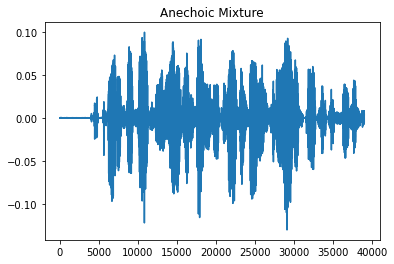

In [2]:
whamr_test_folder_path = '/mnt/data/whamr/wav8k/min/tt'
# wav_path = 'point to a random mixture file of a mixture of 2 speakers'
chosen_file = '447o030x_0.03457_441c0209_-0.03457.wav'
chosen_file = '446o030h_0.13806_444c020w_-0.13806.wav'

wav_path = os.path.join(whamr_test_folder_path, 'mix_clean_anechoic', chosen_file)

ground_truth_sources = torch.tensor(np.array([
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's1_anechoic', chosen_file))[0].detach().numpy()[0],
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's2_anechoic', chosen_file))[0].detach().numpy()[0]
]))

anechoic_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = anechoic_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Anechoic Mixture")
plt.show()
plt.close()

ipd.display(ipd.Audio(waveform, rate=8000))

### Just load a pre-trained model and apply it!

In [3]:
# Load a pretrained model
anechoic_separation_model = torch.load(anechoic_model_p)

# Normalize the waveform and apply the model
input_mix_std = anechoic_sampled_mixture.std(-1, keepdim=True)
input_mix_mean = anechoic_sampled_mixture.mean(-1, keepdim=True)
input_mix = (anechoic_sampled_mixture - input_mix_mean) / (input_mix_std + 1e-9)

# Apply the model
rec_sources_wavs = anechoic_separation_model(input_mix.unsqueeze(1))

# # In case you are using the pre-trained models with Group communication
# # please also use the mixture consistency right after the estimated waveforms
# import sudo_rm_rf.dnn.experiments.utils.mixture_consistency as mixture_consistency
# rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

# Rescale the input sources with the mixture mean and variance
rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean
# It is that simple!

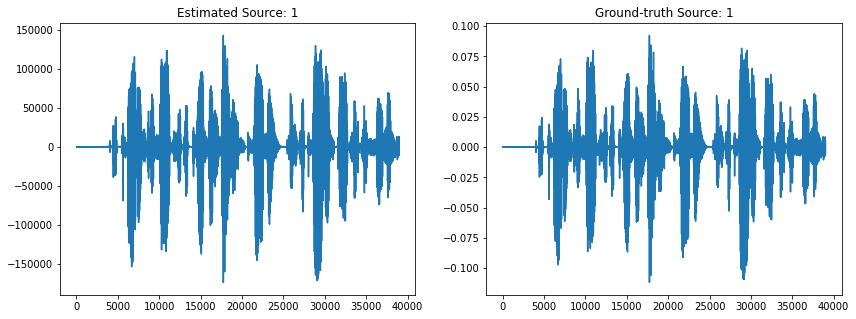

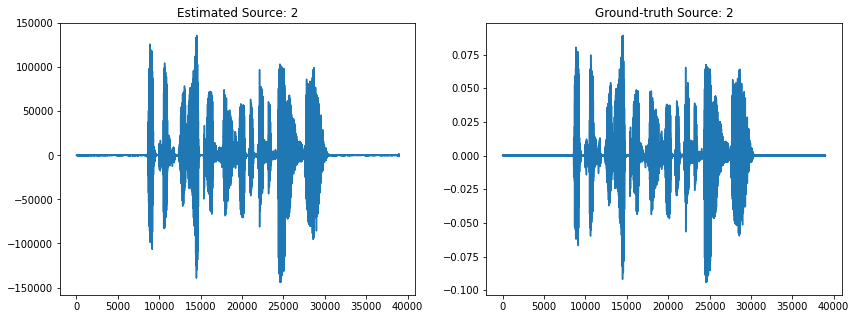

{'input_pesq': 1.5562126636505127,
 'input_sar': 114.70743888982943,
 'input_sdr': 0.09997142639897116,
 'input_si_sdr': -0.05121111869812012,
 'input_sir': 0.09997142643022017,
 'input_stoi': 0.790547723877647,
 'pesq': 3.9126410484313965,
 'sar': 20.55733857383582,
 'sdr': 20.101075576656275,
 'si_sdr': 19.710351943969727,
 'sir': 30.16089871416899,
 'stoi': 0.9916458435906186}


In [4]:
# Plot the separated waveforms and their corresponding metrics 
for src_idx in range(rec_sources_wavs.shape[1]):
    est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
    gt_waveform = ground_truth_sources[src_idx].detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(est_waveform)
    ax[1].plot(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    plt.show()
    plt.close()
    
    ipd.display(ipd.Audio(est_waveform, rate=8000))
    ipd.display(ipd.Audio(gt_waveform, rate=8000))

metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                           normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                           normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                           compute_permutation=True, sample_rate=8000, metrics_list='all')
pprint(metrics_dict)

## Wait... that means that we can Sudo rm -rf also reverberant and noisy sources?

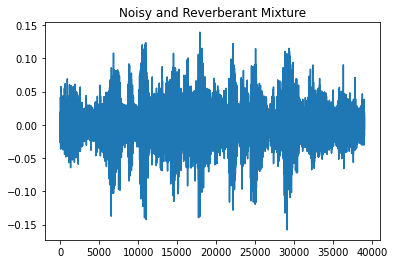

In [5]:
wav_path = os.path.join(whamr_test_folder_path, 'mix_both_reverb', chosen_file)
noisy_reverberant_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = noisy_reverberant_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Noisy and Reverberant Mixture")
plt.show()
plt.close()

ipd.display(ipd.Audio(waveform, rate=8000))

### Of course we can Sudo rm-rf anything!

In [6]:
noisy_and_reverberant_separation_model = torch.load(noisy_reverberant_model_p)

# Normalize the waveform and apply the model
input_mix_std = noisy_reverberant_sampled_mixture.std(-1, keepdim=True)
input_mix_mean = noisy_reverberant_sampled_mixture.mean(-1, keepdim=True)
input_mix = (noisy_reverberant_sampled_mixture - input_mix_mean) / (input_mix_std + 1e-9)

# Apply the model
rec_sources_wavs = noisy_and_reverberant_separation_model(input_mix.unsqueeze(1))

# # In case you are using the pre-trained models with Group communication
# # please also use the mixture consistency right after the estimated waveforms
# import sudo_rm_rf.dnn.experiments.utils.mixture_consistency as mixture_consistency
# rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

# Rescale the input sources with the mixture mean and variance
rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean

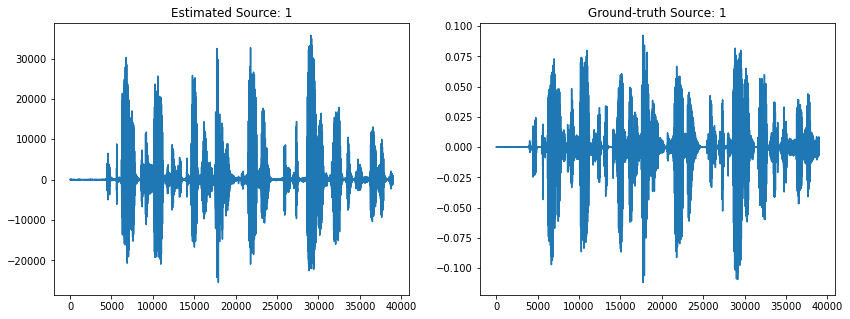

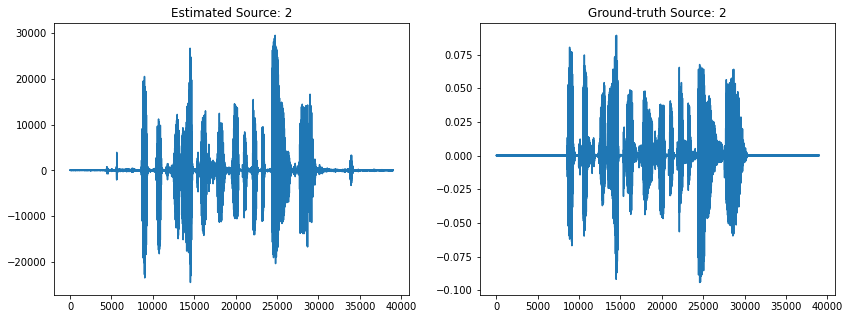

{'input_pesq': 1.326772153377533,
 'input_sar': 2.527989626484339,
 'input_sdr': -3.3407437940132345,
 'input_si_sdr': -6.111439943313599,
 'input_sir': 0.12431474309808466,
 'input_stoi': 0.6224140642689333,
 'pesq': 1.9059551358222961,
 'sar': 9.16236303938991,
 'sdr': 8.93066680077791,
 'si_sdr': 7.081690788269043,
 'sir': 22.843761913966905,
 'stoi': 0.9040309614049471}


In [110]:
# Plot the separated waveforms and their corresponding metrics 
for src_idx in range(rec_sources_wavs.shape[1]):
    est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
    gt_waveform = ground_truth_sources[src_idx].detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(est_waveform)
    ax[1].plot(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    plt.show()
    plt.close()
    
    ipd.display(ipd.Audio(est_waveform, rate=8000))
    ipd.display(ipd.Audio(gt_waveform, rate=8000))

metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                           normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                           normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                           compute_permutation=True, sample_rate=8000, metrics_list='all')
pprint(metrics_dict)